## Introduction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing library in order to see the progress bar
from tqdm.notebook import tnrange, tqdm_notebook
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

In [2]:
# read from the file
df = pd.read_csv('cleaned_twitter_data.csv')

In [3]:
df.shape

(1581247, 13)

In [4]:
df.tail(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
1581245,1,tinydiamondz,happy th birthday to my boo of alll time tup...,NaN,NaN,None,6,16,2009,8,40,49,Tuesday
1581246,1,RyanTrevMorris,happy,"thenspcc, sparkscharity, speakinguph4h",charitytuesday,None,6,16,2009,8,40,50,Tuesday


In [5]:
df.isna().sum()

Sentiment          0
User               0
Tweet              0
Tagging       854040
Hashtags     1546447
Emojis             0
Month              0
Day                0
Year               0
Hour               0
Minutes            0
Seconds            0
DayOfWeek          0
dtype: int64

In [6]:
df['Tagging'] = df['Tagging'].fillna('None')
df['Hashtags'] = df['Hashtags'].fillna('None')

In [7]:
df.isna().sum()

Sentiment    0
User         0
Tweet        0
Tagging      0
Hashtags     0
Emojis       0
Month        0
Day          0
Year         0
Hour         0
Minutes      0
Seconds      0
DayOfWeek    0
dtype: int64

In [8]:
df.shape

(1581247, 13)

### Taking a Sample data

In [9]:
# copying 5% of data
df_chunk = df.sample(frac=0.05).copy()

In [10]:
df_chunk.shape

(79062, 13)

In [11]:
df_chunk['Sentiment'].value_counts().sum()

79062

In [12]:
df_chunk['Sentiment'].value_counts()

0    39615
1    39447
Name: Sentiment, dtype: int64

In [13]:
df_chunk = df_chunk.reset_index(drop=True)

In [14]:
df_chunk.sample(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
40132,0,Dogermad,got woke up at am to babysit my sisters daugh...,None,None,None,5,28,2009,22,26,55,Thursday
69481,1,EmeraldDiscount,morning everyone,None,None,None,6,15,2009,0,48,26,Monday


### working with sample data

In [15]:
# plt.figure(figsize=(10,4))
# df_chunk['Sentiment'].value_counts().plot(kind='bar', rot=0, color=['#FF7F0E', '#3685BC'])
# plt.title("Target Distirbution")
# plt.xlabel("Sentiment")
# plt.ylabel("Count")

# plt.show()

---
### Data Wrangling

In [16]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,kelsey42093,was supposed to get my license today but im not,None,None,None,6,16,2009,21,28,55,Tuesday
1,1,JoeyPerez15,i sent the scanned pages to your email add,discomaniac,None,None,6,15,2009,4,26,6,Monday


In [18]:
X = pd.DataFrame(df_chunk['Tweet']) # indep
y = df_chunk["Sentiment"] # dep

In [19]:
X.head()

,Tweet
0,was supposed to get my license today but im not
1,i sent the scanned pages to your email add
2,thanks to the vista drivers my wacom graphire ...
3,sent ya a quick dm just funny to me awe loo...
4,yes it is and i am loving it just got hone lay...


#### Check the shape of the Data

In [20]:
X.shape

(79062, 1)

In [21]:
y.shape

(79062,)

In [22]:
# Test set 20 percent
X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [23]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [24]:
print(f'Shape of X-test set: {X_test.shape}')
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of X-test set: (15813, 1)
Shape of X remainder set: (63249, 1)
Shape of validation set: (18975, 1)
Shape of train set: (44274, 1)


Our final proportions end up being
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

In [38]:
bagofwords_vector = CountVectorizer(stop_words="english")

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [39]:
X_train_transform

<44274x35057 sparse matrix of type '<class 'numpy.int64'>'
	with 275686 stored elements in Compressed Sparse Row format>

In [40]:
len(bagofwords_vector.get_feature_names_out())

35057

In [41]:
np.mean(X_train_transform.toarray().sum(axis=0))


8.037139515645949

Based on the mean we try min_df of ~8

In [42]:
bagofwords_vector = CountVectorizer(stop_words="english", min_df=8)

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [43]:
X_train_transform

<44274x3883 sparse matrix of type '<class 'numpy.int64'>'
	with 224123 stored elements in Compressed Sparse Row format>

In [44]:
len(bagofwords_vector.get_feature_names_out())

3883

In [45]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
my_df = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
display(my_df)

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yuck,yucky,yum,yummy,yup,zach,zealand,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
my_df.shape[0] == X_train.shape[0]

True

In [58]:
# pip install nltk

### Vectorisation using Count Vectorizer model

In [25]:
import nltk
from nltk.stem import WordNetLemmatizer

# Let's test it out
# stemmer = nltk.stem.PorterStemmer()

In [29]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...


True

In [50]:
lemmatizer = WordNetLemmatizer()

bagofwords_vector = CountVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer.lemmatize(i) for i in x.split()], min_df=8)
# 2. Fit
bagofwords_vector.fit(X_train['Tweet'])

CountVectorizer(min_df=8, stop_words='english',
                tokenizer=<function <lambda> at 0x7f5d3332d510>)

In [51]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [52]:
X_train_transform

<44274x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 235260 stored elements in Compressed Sparse Row format>

In [53]:
X_val_transform

<18975x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 100528 stored elements in Compressed Sparse Row format>

In [54]:
X_test_transform

<15813x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 82409 stored elements in Compressed Sparse Row format>

15813 features to 4668 feature

In [55]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
X_train_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_val_transform.toarray())
X_val_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_test_transform.toarray())
X_test_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
words = bagofwords_vector.get_feature_names_out()
some_indices = range(1, 3708, round(3708/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaron', 'boyle', 'cure', 'fault', 'hehehe', 'level', 'nz', 'really', 'sorted', 'trouble']


In [59]:
counts = np.array(X_train_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaron,boyle,cure,fault,hehehe,level,nz,really,sorted,trouble
total_corpus_count,11,17,13,22,28,27,12,1339,11,45


In [60]:
bagofwords_vector.get_feature_names_out()

array(['aaah', 'aaron', 'ab', ..., 'zombie', 'zone', 'zoo'], dtype=object)

In [61]:
word_counts = pd.DataFrame(
    {"counts": X_train_transform.toarray().sum(axis=0)},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("counts", ascending=False)

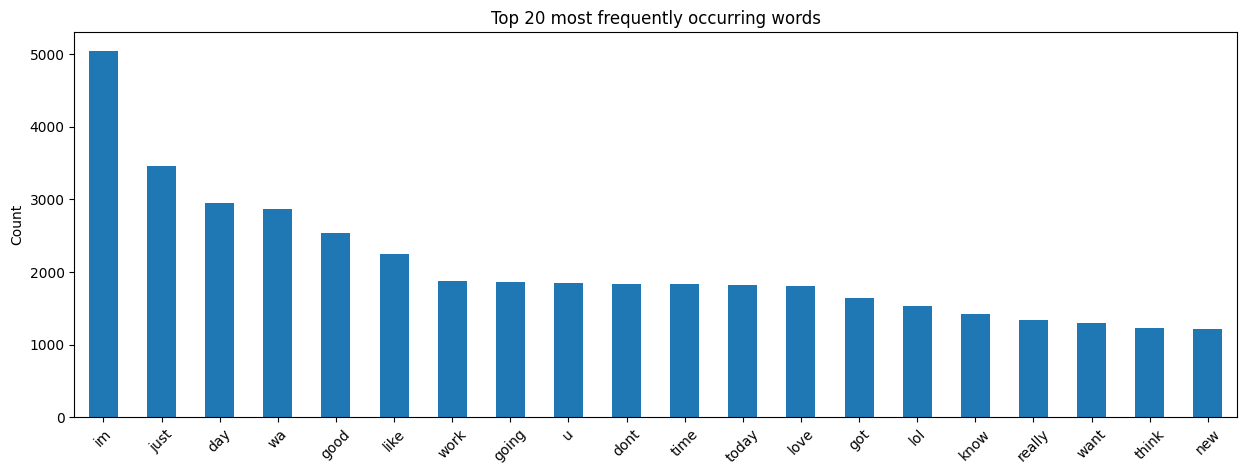

In [62]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Vectorisation using TF-IDF model

In [26]:
lemmatizer_tfidf = WordNetLemmatizer()

tfidf_vector = TfidfVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer_tfidf.lemmatize(i) for i in x.split()], min_df=3)
# 2. Fit
tfidf_vector.fit(X_rem['Tweet'])

TfidfVectorizer(min_df=3, stop_words='english',
                tokenizer=<function <lambda> at 0x7f885d2169e0>)

In [27]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_rem_tfidf_transform = tfidf_vector.transform(X_rem['Tweet'])
X_test_tfidf_transform = tfidf_vector.transform(X_test['Tweet'])

In [28]:
X_rem_tfidf_transform

<63249x10093 sparse matrix of type '<class 'numpy.float64'>'
	with 367521 stored elements in Compressed Sparse Row format>

In [29]:
X_test_tfidf_transform

<15813x10093 sparse matrix of type '<class 'numpy.float64'>'
	with 91058 stored elements in Compressed Sparse Row format>

In [30]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_rem_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_rem_tfidf_transform.toarray())
X_rem_df_tfidf_vect

,aa,aaaaahhh,aaaah,aaaand,aaaargh,aaah,aaahhh,aaahhhh,aaand,aaaww,...,zomg,zone,zonked,zoo,zoom,zu,zune,zz,zzz,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_test_tfidf_transform.toarray())
X_test_df_tfidf_vect

,aa,aaaaahhh,aaaah,aaaand,aaaargh,aaah,aaahhh,aaahhhh,aaand,aaaww,...,zomg,zone,zonked,zoo,zoom,zu,zune,zz,zzz,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#sanity check - to make sure the shape are equal
X_rem_df_tfidf_vect.shape[0] == X_rem.shape[0]

True

In [36]:
#Checking the shape of the summary dataframe
print(f'There are {X_rem_df_tfidf_vect.shape[0]} rows, and {X_rem_df_tfidf_vect.shape[1]} columns in the X_train summary dataframe')

There are 63249 rows, and 10093 columns in the X_train summary dataframe


In [37]:
words = tfidf_vector.get_feature_names_out()
some_indices = range(1, 10093, round(10093/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaaaahhh', 'book', 'creeper', 'extra', 'helpful', 'lettuce', 'nottingham', 'raped', 'snagged', 'trapped', 'zzz']


In [40]:
counts = np.array(X_rem_tfidf_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaaaahhh,book,creeper,extra,helpful,lettuce,nottingham,raped,snagged,trapped,zzz
total_corpus_count,1.607562,106.091104,1.98343,28.130422,8.65387,3.235049,2.723338,2.294511,1.315193,2.342502,4.028539


---
### Logistic Regression on TF-IDF Vectorizer

In [41]:
from sklearn.linear_model import LogisticRegression

In [44]:
# Initializing Scale
scaler = RobustScaler()

# Fitting scale
scaler.fit(X_rem_df_tfidf_vect)

# Transform scale
X_rem_scaled = scaler.transform(X_rem_df_tfidf_vect)
X_test_scaled = scaler.transform(X_test_df_tfidf_vect)

In [46]:
# instantiate model
logreg_model = LogisticRegression(max_iter=10000, random_state=1)

# fit the model
logreg_model.fit(X_rem_scaled, y_rem)

LogisticRegression(max_iter=10000, random_state=1)

In [48]:
# Training and test score
print(f"Train score: {logreg_model.score(X_rem_scaled, y_rem)}")
print(f"Validation score: {logreg_model.score(X_test_scaled, y_test)}")

Train score: 0.8000126484213189
Validation score: 0.745715550496427


In [49]:
logreg_model.coef_[0]

array([-1.01089155, -0.28058302, -0.50005181, ...,  0.53142093,
       -0.54849368,  0.39790859])

In [51]:
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model.coef_[0]},
    index=tfidf_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

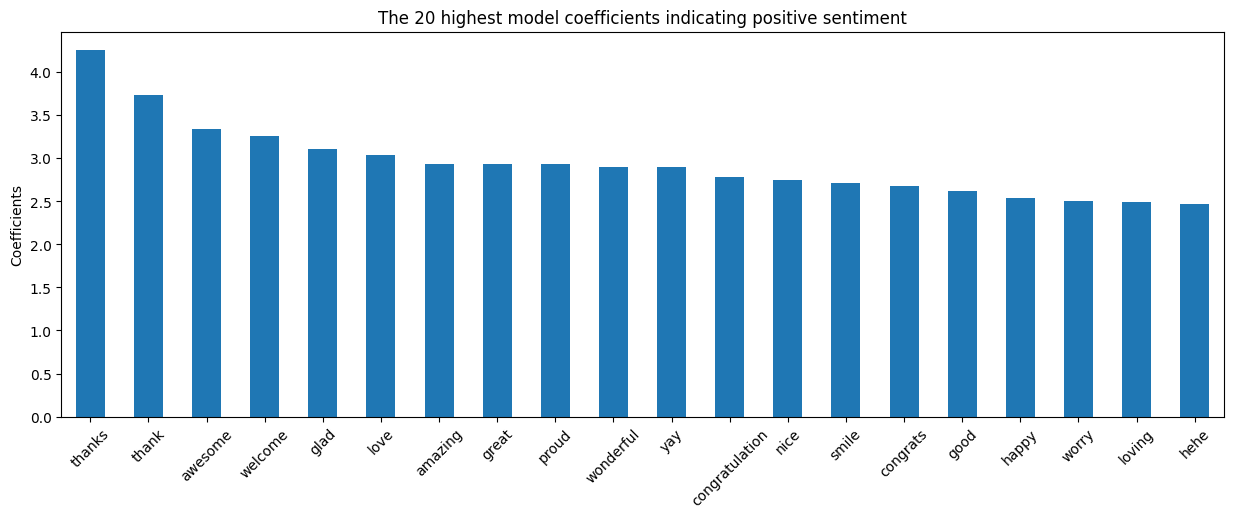

In [52]:
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

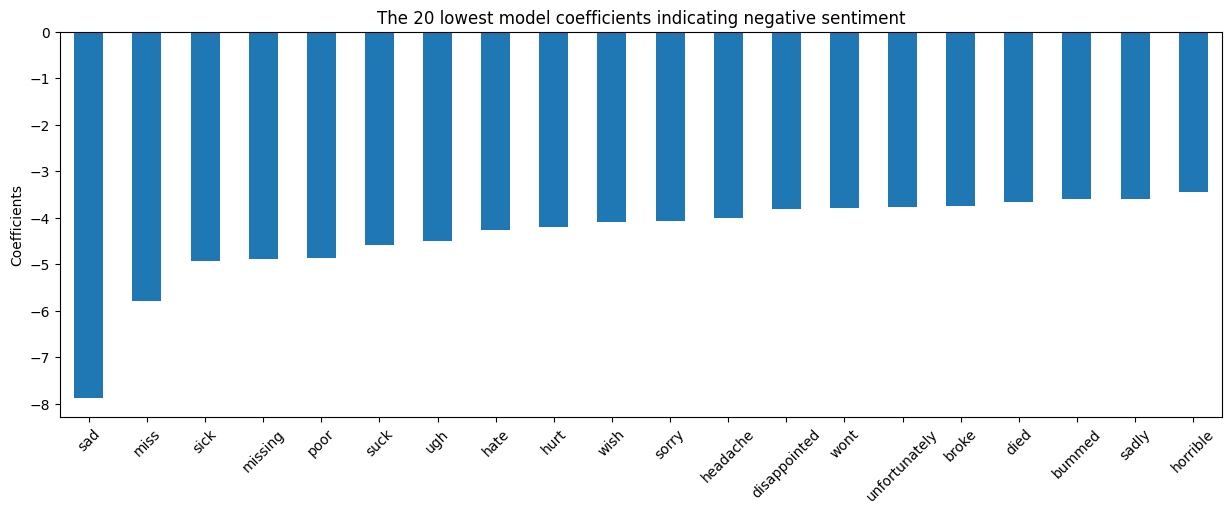

In [53]:
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [54]:
word_coefficients

,coefficients
thanks,4.257815
thank,3.739004
awesome,3.344982
welcome,3.255888
glad,3.102311
...,...
poor,-4.867569
missing,-4.889978
sick,-4.933716
miss,-5.798719


### Confusion Matrix for the LogisticRegression

In [55]:
#Import the confusion matrix libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Importing the classification report library
from sklearn.metrics import classification_report

In [56]:
# Importing precision and recall score libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [58]:
# Get class predictions
y_pred = logreg_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5766,2157
True Positive,1864,6026


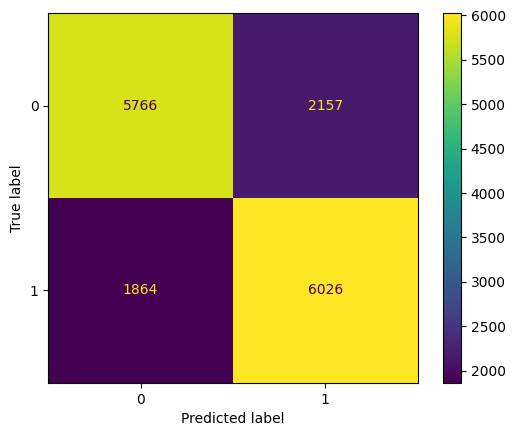

In [60]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test_scaled, y_test)

In [61]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      7923
           1       0.74      0.76      0.75      7890

    accuracy                           0.75     15813
   macro avg       0.75      0.75      0.75     15813
weighted avg       0.75      0.75      0.75     15813



In [63]:
# Make probabilistic predictions (scores)
y_proba = logreg_model.predict_proba(X_test_scaled)[:,1]

In [68]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7364047415373335
Recall score: 0.7637515842839037

Threshold of 0.2:
Precision score: 0.588290034897247
Recall score: 0.9614702154626109


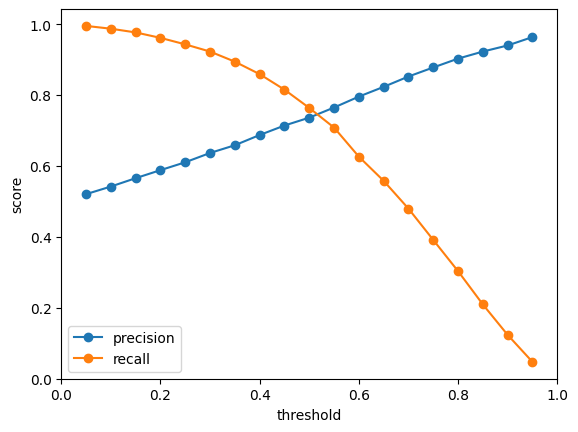

In [69]:
from sklearn.metrics import accuracy_score

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

### Including n-grams

In [70]:
lemmatizer_tfidf = WordNetLemmatizer()

tfidf_vector = TfidfVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer_tfidf.lemmatize(i) for i in x.split()], min_df=3, max_features=2000, ngram_range=(1, 3))
# 2. Fit
tfidf_vector.fit(X_rem['Tweet'])

# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_rem_tfidf_transform = tfidf_vector.transform(X_rem['Tweet'])
X_test_tfidf_transform = tfidf_vector.transform(X_test['Tweet'])

In [71]:
X_rem_tfidf_transform

<63249x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 320176 stored elements in Compressed Sparse Row format>

In [72]:
X_test_tfidf_transform

<15813x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 80317 stored elements in Compressed Sparse Row format>

In [74]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_rem_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_rem_tfidf_transform.toarray())
X_rem_df_tfidf_vect

,able,absolutely,abt,account,ache,acting,action,actually,ad,adam,...,youre,youre right,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
63245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.54472,0.0,0.0,0.0,0.0,0.0
63246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
63247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [75]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_test_tfidf_transform.toarray())
X_test_df_tfidf_vect

,able,absolutely,abt,account,ache,acting,action,actually,ad,adam,...,youre,youre right,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
#sanity check - to make sure the shape are equal
X_rem_df_tfidf_vect.shape[0] == X_rem.shape[0]

True

In [77]:
#Checking the shape of the summary dataframe
print(f'There are {X_rem_df_tfidf_vect.shape[0]} rows, and {X_rem_df_tfidf_vect.shape[1]} columns in the X_train summary dataframe')

There are 63249 rows, and 2000 columns in the X_train summary dataframe


In [82]:
words = tfidf_vector.get_feature_names_out()
some_indices = range(1, 2000, round(2000/10))
samples = [words[i] for i in some_indices]
print(samples)

['absolutely', 'bummed', 'difference', 'forget', 'horrible', 'learning', 'network', 'really want', 'stay', 'ugh']


In [83]:
counts = np.array(X_rem_tfidf_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,absolutely,bummed,difference,forget,horrible,learning,network,really want,stay,ugh
total_corpus_count,40.386231,30.202928,16.952309,54.48602,48.912554,36.861584,20.813835,45.569332,101.945969,166.030623


### Logistic Regression TF-IDF vectorizer after including n-grams

In [84]:
# Initializing Scale
scaler = RobustScaler()

# Fitting scale
scaler.fit(X_rem_df_tfidf_vect)

# Transform scale
X_rem_tfidf_scaled = scaler.transform(X_rem_df_tfidf_vect)
X_test_tfidf_scaled = scaler.transform(X_test_df_tfidf_vect)

In [89]:
# instantiate model
logreg_model_tfidf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# fit the model
logreg_model_tfidf.fit(X_rem_tfidf_scaled, y_rem)

# Training and test score
print(f"Train score: {logreg_model_tfidf.score(X_rem_tfidf_scaled, y_rem)}")
print(f"Test score: {logreg_model_tfidf.score(X_test_tfidf_scaled, y_test)}")

Train score: 0.7648974687346836
Test score: 0.7361664453297919


In [90]:
# Get class predictions
y_pred = logreg_model_tfidf.predict(X_test_tfidf_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5654,2269
True Positive,1903,5987


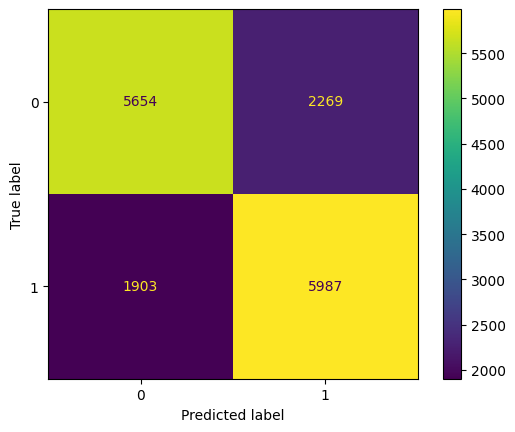

In [91]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model_tfidf, X_test_tfidf_scaled, y_test)

In [92]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      7923
           1       0.73      0.76      0.74      7890

    accuracy                           0.74     15813
   macro avg       0.74      0.74      0.74     15813
weighted avg       0.74      0.74      0.74     15813



In [93]:
# Make probabilistic predictions (scores)
y_proba = logreg_model_tfidf.predict_proba(X_test_tfidf_scaled)[:,1]

In [94]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7251695736434108
Recall score: 0.758808618504436

Threshold of 0.2:
Precision score: 0.5886739687718481
Recall score: 0.9604562737642586


In [100]:
y_proba

array([0.81225472, 0.21913737, 0.43115354, ..., 0.35310816, 0.27861393,
       0.48765057])

### Saving file

In [96]:
X_rem_df_tfidf_vect.to_csv('rem_vectorized.csv', index=False)
X_test_df_tfidf_vect.to_csv('test_vectorized.csv', index=False)

In [99]:
y_rem.to_csv('y_rem.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [98]:
#sanity check
check_df = pd.read_csv('rem_vectorized.csv')
check_df

,able,absolutely,abt,account,ache,acting,action,actually,ad,adam,...,youre,youre right,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
63245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.54472,0.0,0.0,0.0,0.0,0.0
63246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
63247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
